In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORT LIBRARY**

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from termcolor import colored
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Import pustaka yang diperlukan
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

 ***EDA Data Images***

In [3]:
folder_tvt_path = '/content/drive/MyDrive/ship_classification1'
full_path = '/content/drive/MyDrive/224x224data'

train_path = os.path.join(folder_tvt_path, 'train')
val_path = os.path.join(folder_tvt_path, 'validation')
test_path = os.path.join(folder_tvt_path, 'test')

1. Grafik Perhitungan Pada Data

- Total gambar dari tiap class

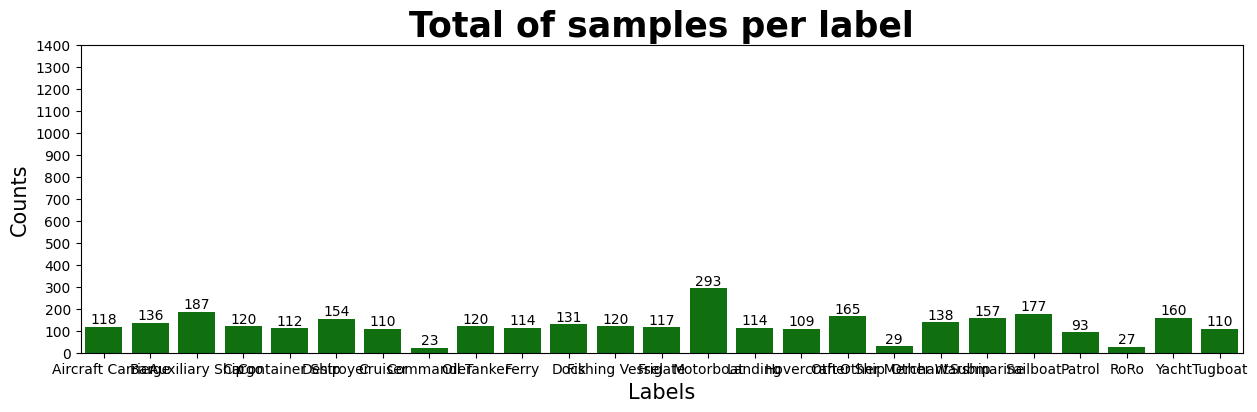

In [4]:
classes = [class_name for class_name in os.listdir(full_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(full_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Total of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

- Total gambar file class dari train directory

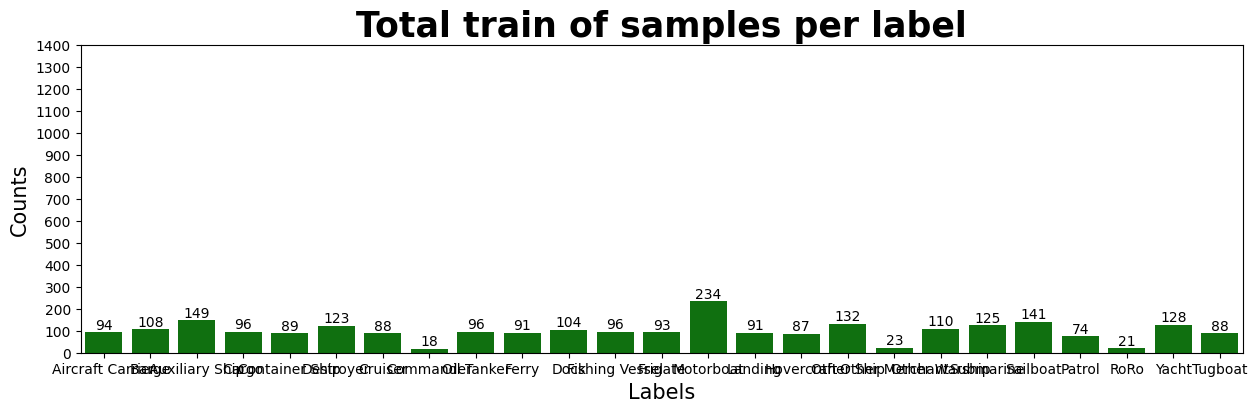

In [5]:
classes = [class_name for class_name in os.listdir(train_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Total train of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

- Total gambar file class dari validation directory

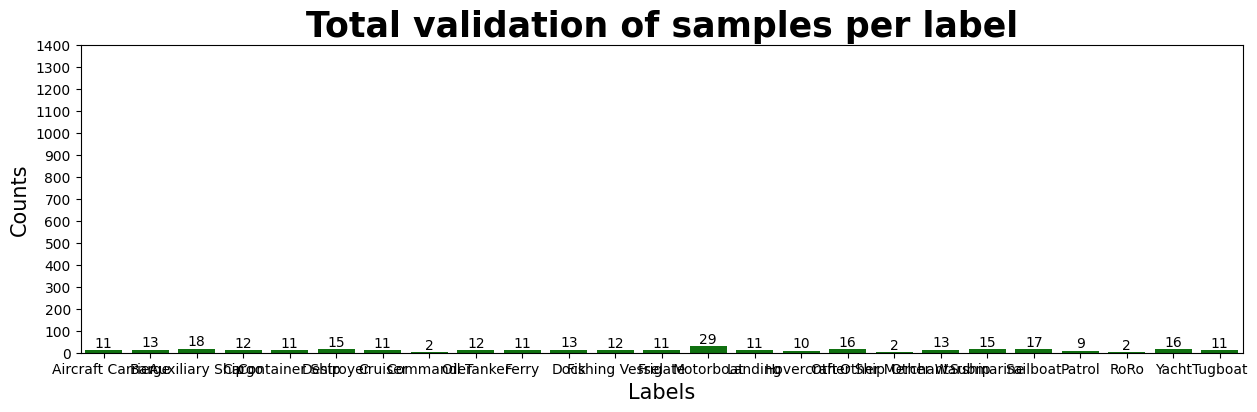

In [6]:
classes = [class_name for class_name in os.listdir(val_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(val_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Total validation of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

- Total gambar file class dari test directory

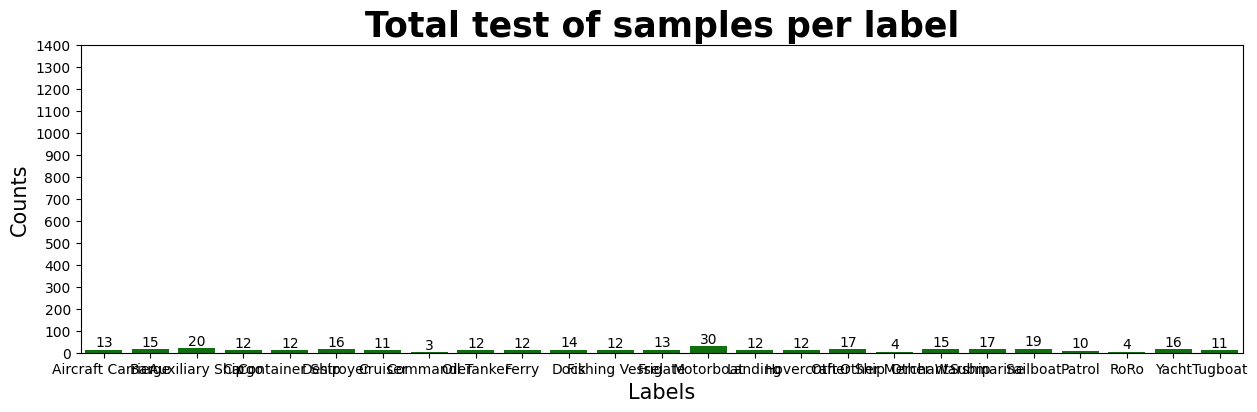

In [7]:
classes = [class_name for class_name in os.listdir(test_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(test_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Total test of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

2. Cek Validasi Gambar Pada Setiap Class

In [8]:
 def check_images(path):
     for subdir, dirs, files in os.walk(path):
         for file in files:
             file_path = os.path.join(subdir, file)
             try:
                 img = Image.open(file_path) # open image file
                 img.verify() # image verify
             except (IOError, SyntaxError) as e:
                 print('Bad file:', file_path)

 check_images(train_path)
 check_images(val_path)
 check_images(test_path)

3. Menampilkan Total File Dan Class

In [9]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_path)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [10]:
num_of_classes(train_path, 'train')
num_of_classes(val_path, 'validation')
num_of_classes(test_path, 'test')

number of classes in train folder : 25
number of classes in validation folder : 25
number of classes in test folder : 25


In [11]:
# A function to return DataFrame
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [12]:
train_df = create_df(train_path)
validation_df = create_df(val_path)
test_df = create_df(test_path)

print(colored(f'Total files : {len(train_df) + len(validation_df) + len(test_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Total files : 3134
Number of samples in train : 2499
Number of samples in validation : 303
Number of samples test : 332


 4. Menampilkan Visualisasi Pada Data

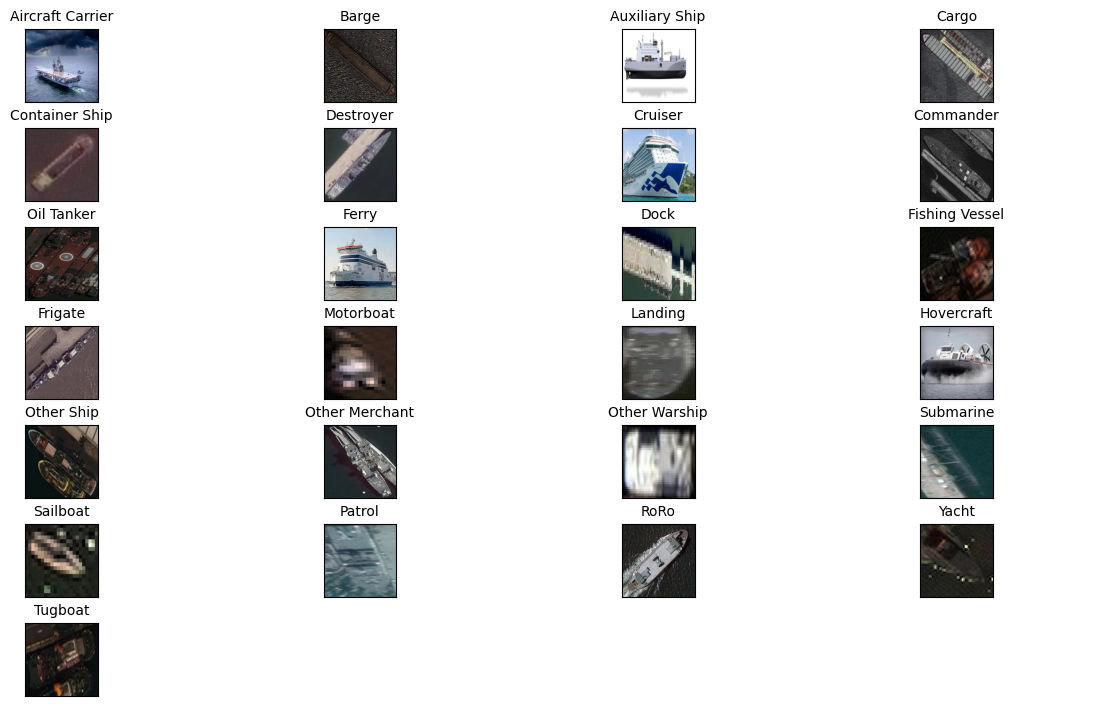

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 4) + 1
ncols = min(num_unique_labels, 4)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


***Menyiapkan Dataset***

> Memuat Data Pelatihan

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb'
)

Found 2499 images belonging to 25 classes.


> Augmentasi data

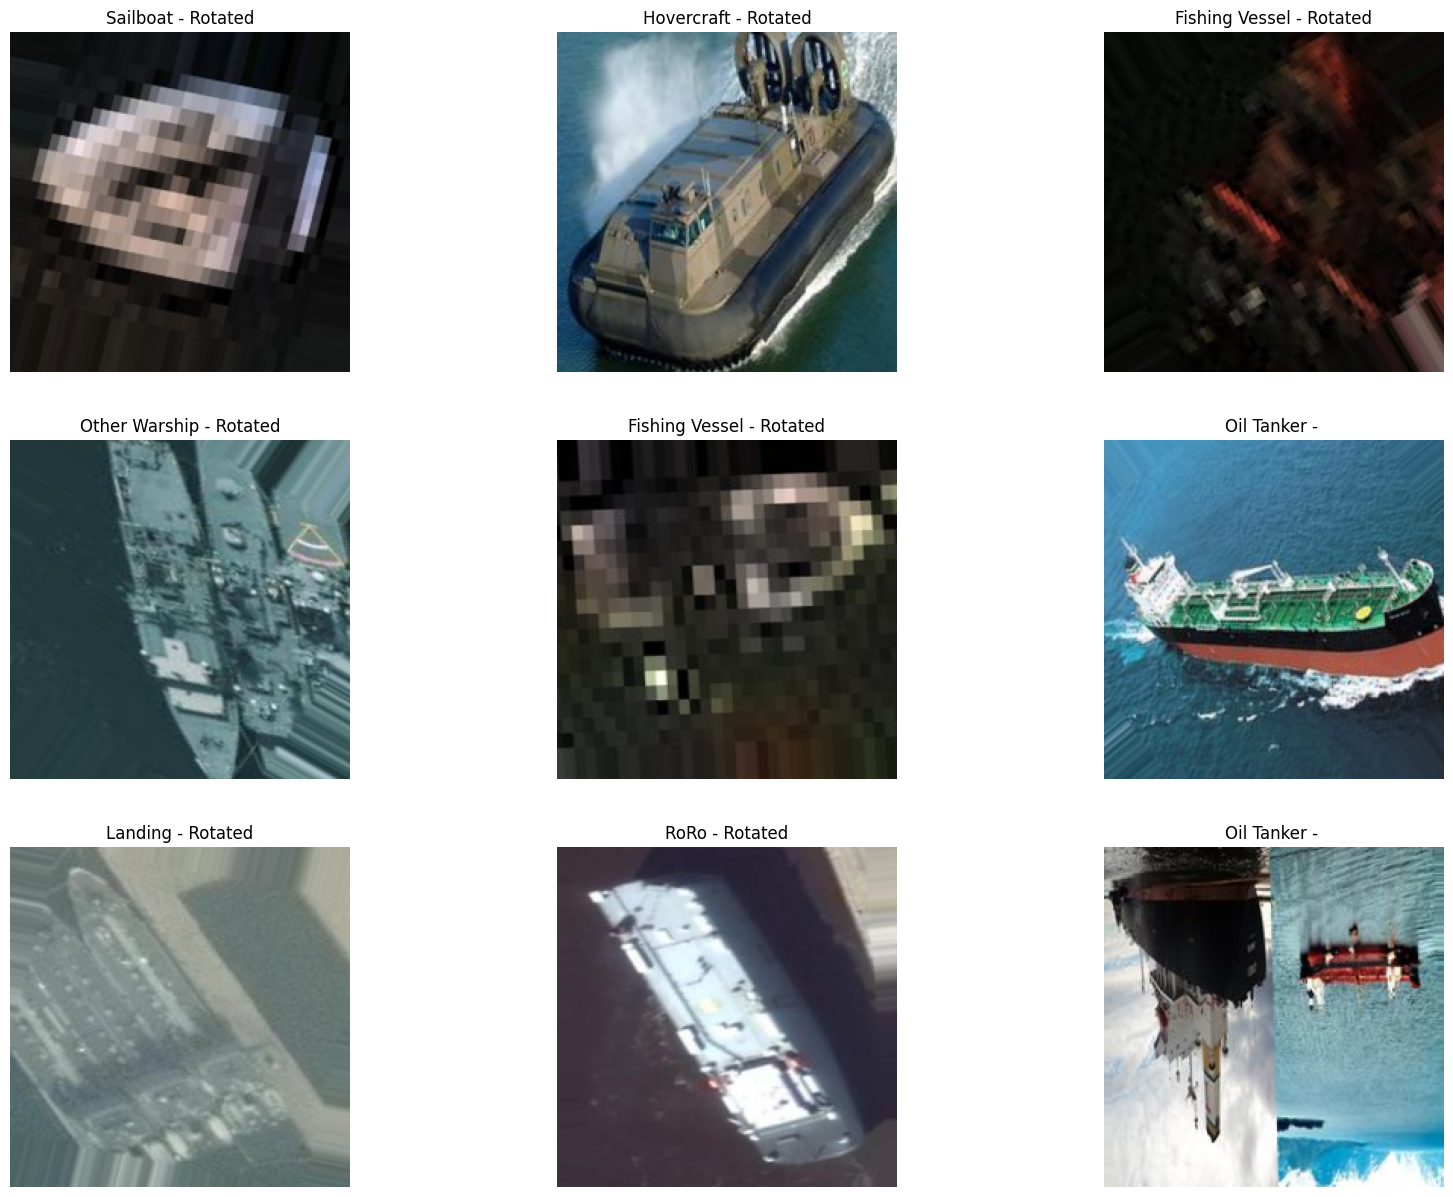

In [15]:
augmented_images, labels = next(train_generator)

# Tampilkan gambar augmentasi dengan label dan jenis augmentasi
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
class_names = list(train_generator.class_indices.keys())

for i in range(9):
    ax = axes[i//3, i%3]
    ax.imshow(augmented_images[i])
    aug_type = []
    if labels[i].any():
        aug_type.append("Flipped" if np.array_equal(augmented_images[i], np.flipud(augmented_images[i])) else "")
        aug_type.append("Rotated" if np.max(augmented_images[i]) != np.max(augmented_images[i-1]) else "")
        aug_type.append("Zoomed" if augmented_images[i].shape != augmented_images[i-1].shape else "")
        # aug_type.append("Brightness Adjusted")
    ax.set_title(f"{class_names[np.argmax(labels[i])]} - {', '.join([x for x in aug_type if x])}")
    ax.axis('off')



> Memuat Data Validasi

In [16]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb',
)

Found 303 images belonging to 25 classes.


>Penggunaan Augmentasi

In [17]:
test_datagen = ImageDataGenerator(1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 332 images belonging to 25 classes.


In [18]:
x, y = next(train_generator)
print("Images shape:", x.shape)


Images shape: (32, 224, 224, 3)


>Pemetaan Label dan Nama Class

In [19]:
labels = {value: key for key, value in train_generator.class_indices.items()}
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Aircraft Carrier
1 : Auxiliary Ship
2 : Barge
3 : Cargo
4 : Commander
5 : Container Ship
6 : Cruiser
7 : Destroyer
8 : Dock
9 : Ferry
10 : Fishing Vessel
11 : Frigate
12 : Hovercraft
13 : Landing
14 : Motorboat
15 : Oil Tanker
16 : Other Merchant
17 : Other Ship
18 : Other Warship
19 : Patrol
20 : RoRo
21 : Sailboat
22 : Submarine
23 : Tugboat
24 : Yacht


***BUILD MODEL CNN***

1. Build Model Convolutional Neural Network

In [27]:
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.Input(shape=(224, 224, 3)),

    # hidden layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    # fully connected
    tf.keras.layers.Dense(units=512, activation='relu'),

    # ouput layer
    tf.keras.layers.Dense(units=25, activation='softmax')
])

2. Tampilan Pada Model Diagram

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 111, 111, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 55, 55, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 13, 13, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │          12,825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,669,721 (10.18 MB)

 Trainable params: 2,669,721 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
!pip install pydot
!pip install graphviz

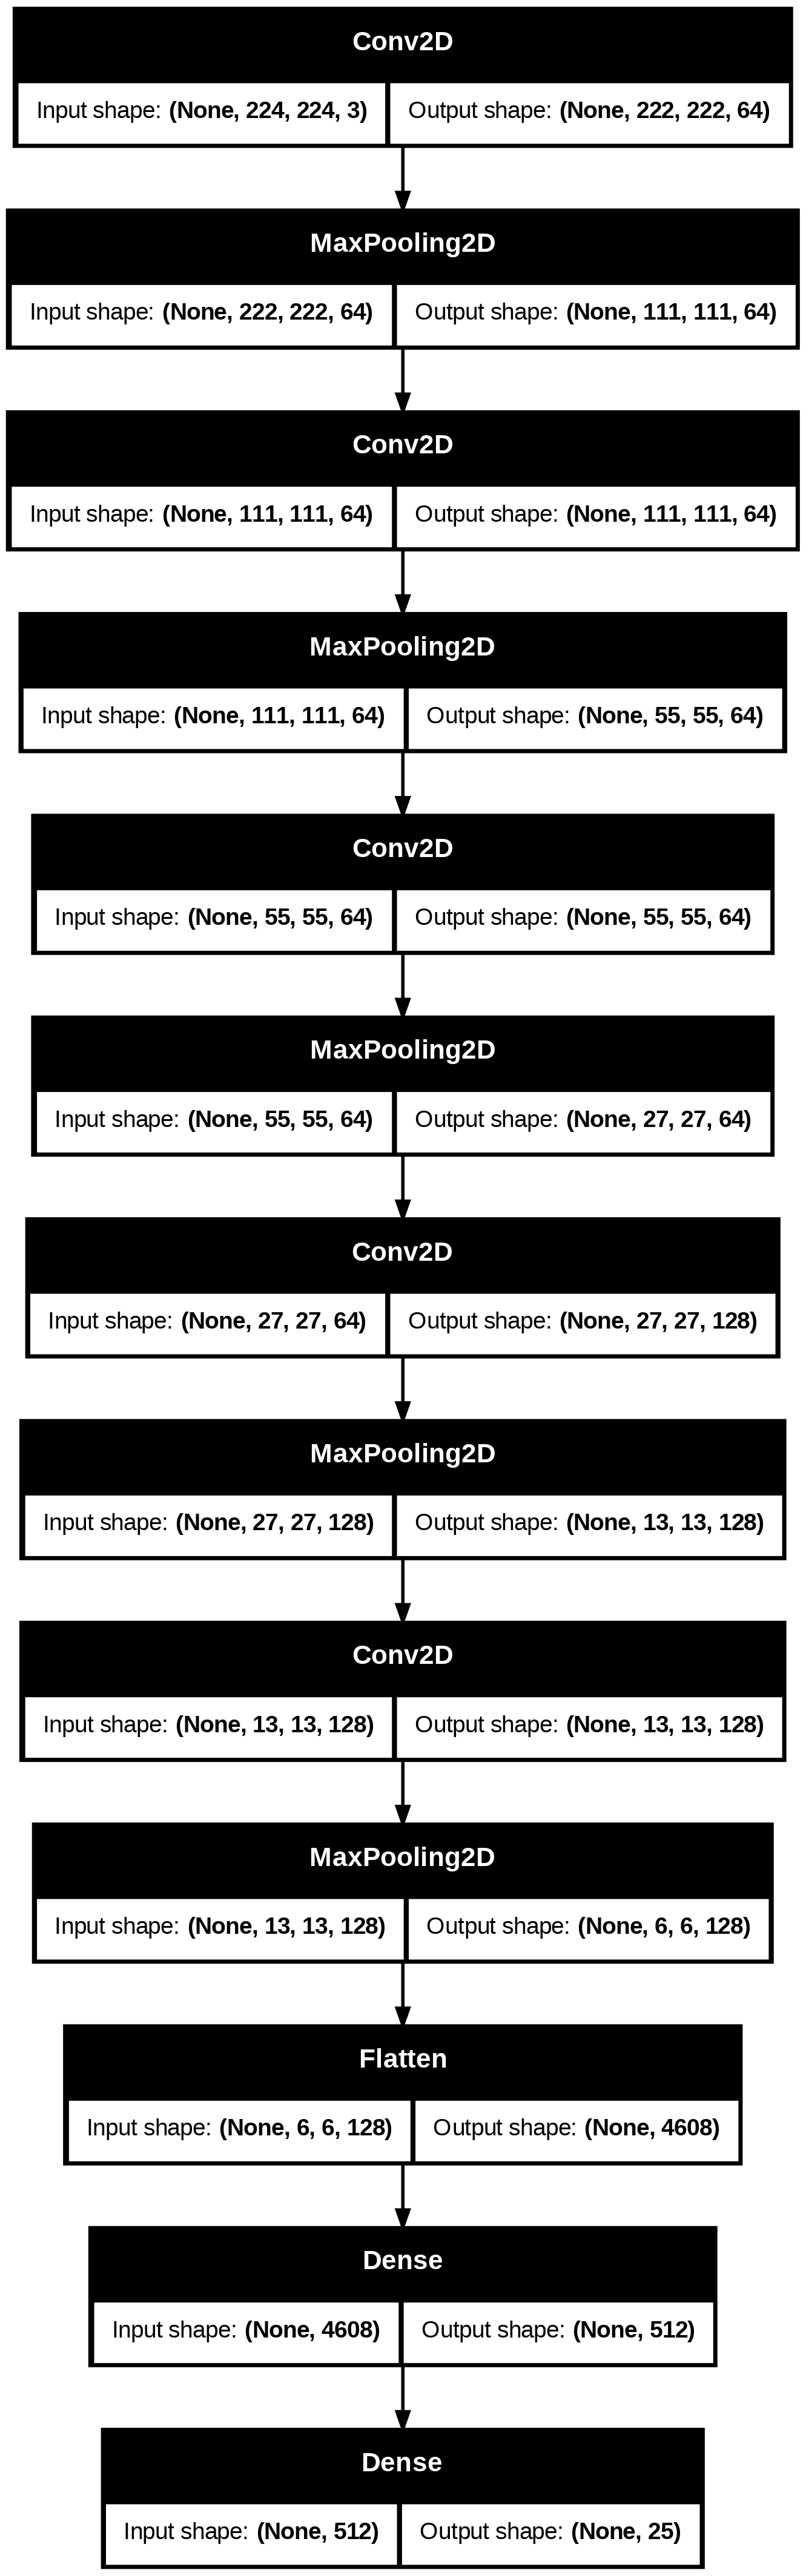

In [30]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

3. Menyusun Model

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

4. Callback pada Model Convolutional Neural Network

In [32]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint(
    'my_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stoping
earlystop_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=3,
    verbose=1,
    mode='min'
)

5. Pelatihan Pada Model Convolutional Neural Network

batch adalah sekumpulan sampel yang digunakan untuk mengupdate parameter model dalam satu iterasi selama proses pelatihan.

In [35]:
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3464 - loss: 2.0358
Epoch 1: val_loss improved from 2.27954 to 2.18563, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.3463 - loss: 2.0361 - val_accuracy: 0.3531 - val_loss: 2.1856 - learning_rate: 1.0000e-04
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3294 - loss: 2.0208
Epoch 2: val_loss did not improve from 2.18563
79/79 ━━━━━━━━━━━━━━━━━━━━ 473s 6s/step - accuracy: 0.3297 - loss: 2.0205 - val_accuracy: 0.2442 - val_loss: 2.2678 - learning_rate: 1.0000e-04
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3608 - loss: 1.9843
Epoch 3: val_loss did not improve from 2.18563
79/79 ━━━━━━━━━━━━━━━━━━━━ 473s 6s/step - accuracy: 0.3606 - loss: 1.9844 - val_accuracy: 0.2772 - val_loss: 2.2366 - learning_rate: 1.0000e-04
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3655 - loss: 1.9854
Epoch 4: val_loss improved from 2.18563 to 2.10686, saving 

 ***Hasil Dari Pelatihan Pada Data***

> Menampilkan Riwayat Pelatihan Pada Model

In [36]:
result_data = pd.DataFrame(history.history)
result_data.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
15  0.476991  1.632011      0.369637  2.061008       0.000010
16  0.477391  1.616354      0.372937  2.036121       0.000010
17  0.474590  1.628335      0.379538  2.045231       0.000010
18  0.477391  1.611751      0.369637  2.037671       0.000003
19  0.483794  1.603877      0.359736  2.052781       0.000003

> Analisis Performa pada Model dan Menampilkan Grafik Hasil

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

lr = history.history['learning_rate']

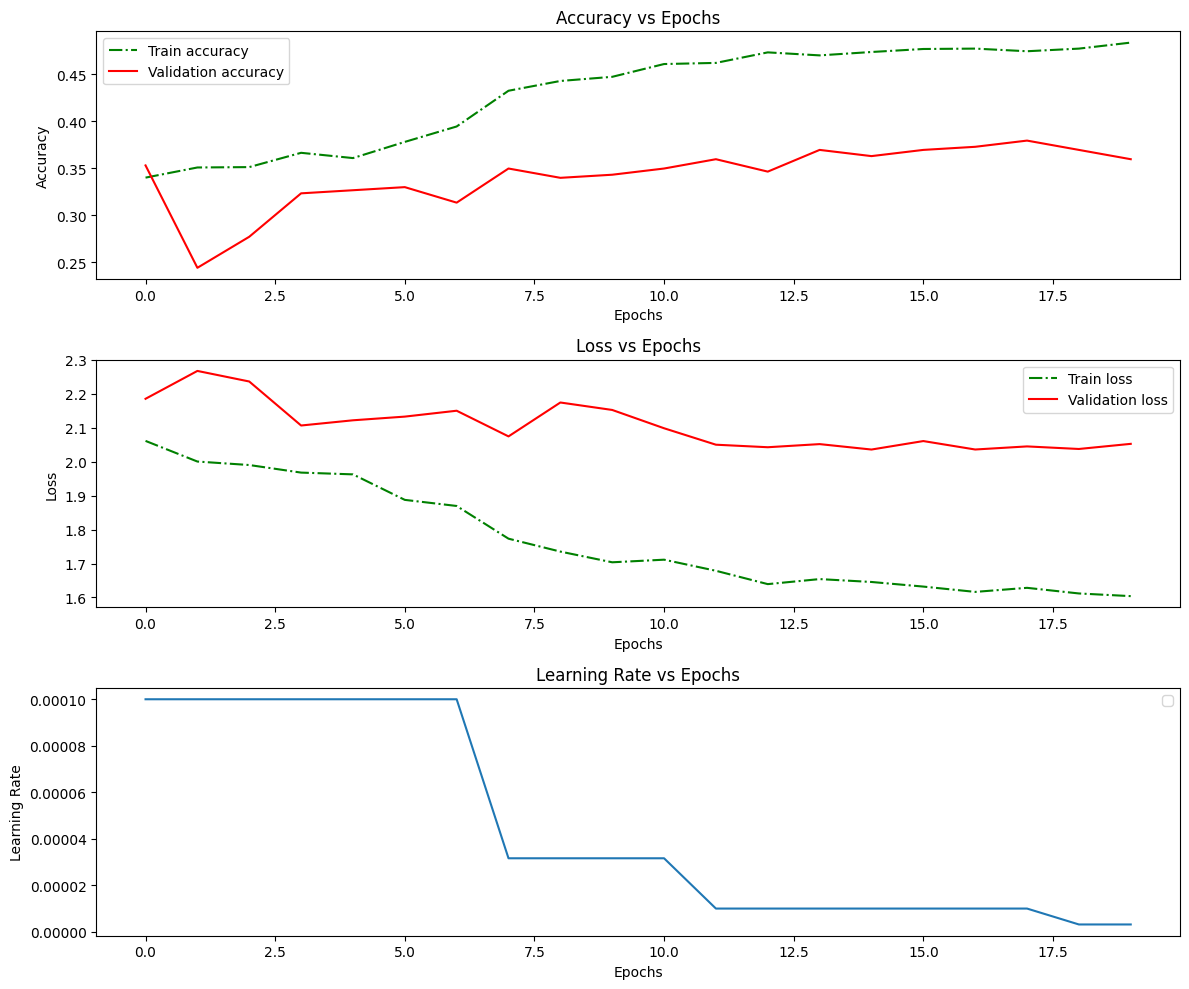

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(train_accuracy, '-.', label='Train accuracy', c='g')
ax[0].plot(val_accuracy, '-', label='Validation accuracy', c='r')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].set_title('Loss vs Epochs')
ax[1].plot(train_loss, '-.', label='Train loss', c='g')
ax[1].plot(val_loss, '-', label='Validation loss', c='r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].set_title('Learning Rate vs Epochs')
ax[2].plot(lr, '-')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning Rate')
ax[2].legend()

plt.tight_layout()
plt.show()

 ***Tes Pada Model***

> Prediksi Model

In [39]:
prediction = model.predict(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


> Menampilkan Hasil Prediksi Model Pada Data Uji

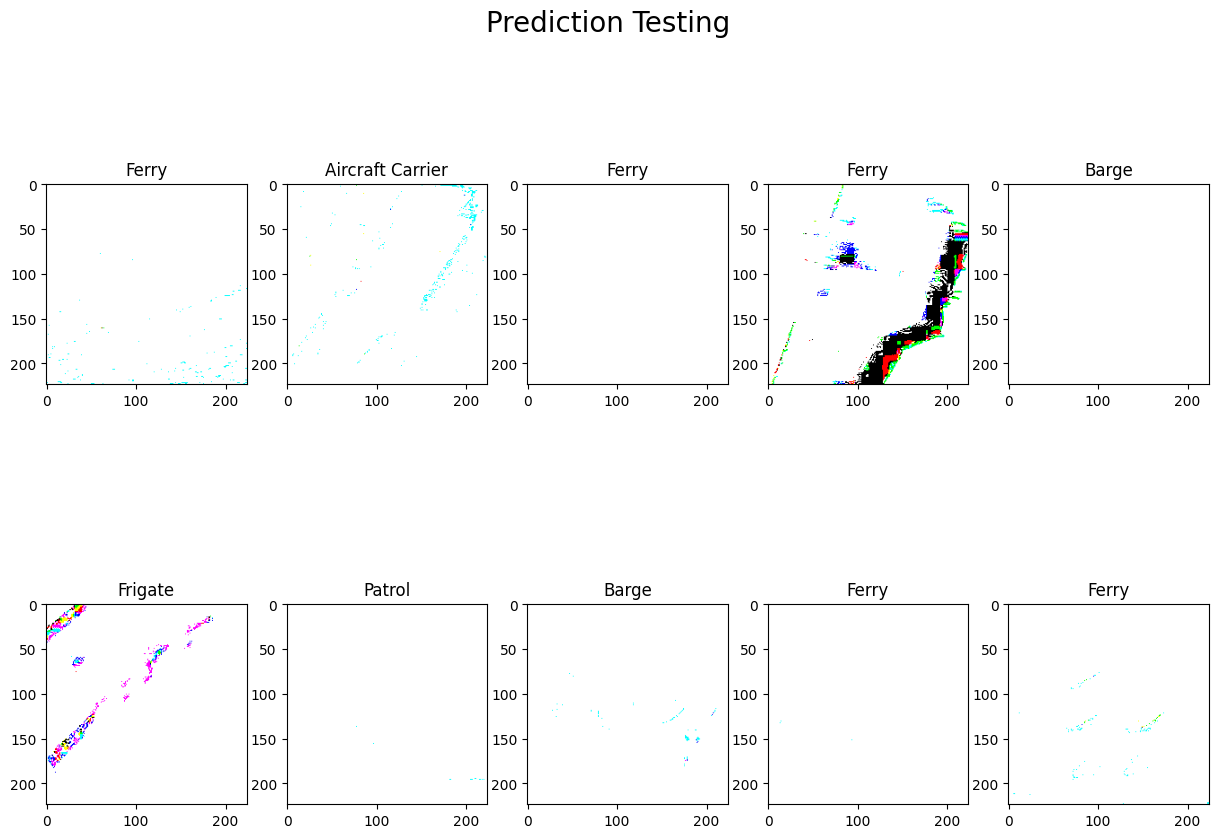

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(5):
        prediction_class = class_map[np.argmax(prediction[idx])]
        ax[i, j].set_title(f"{prediction_class}")
        ax[i, j].imshow(test_generator[0][0][idx])
        idx += 1

plt.suptitle('Prediction Testing', fontsize=20)
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1754 - loss: 384.6961


In [42]:
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy} -> {100*test_accuracy:.2f}%")

Test loss: 396.8218994140625
Test accuracy: 0.1807228922843933 -> 18.07%


# **PLOT TEST MODEL**

i. define y_hat and y

In [43]:
y_hat = np.argmax(prediction, axis=1)
y_true = test_generator.classes

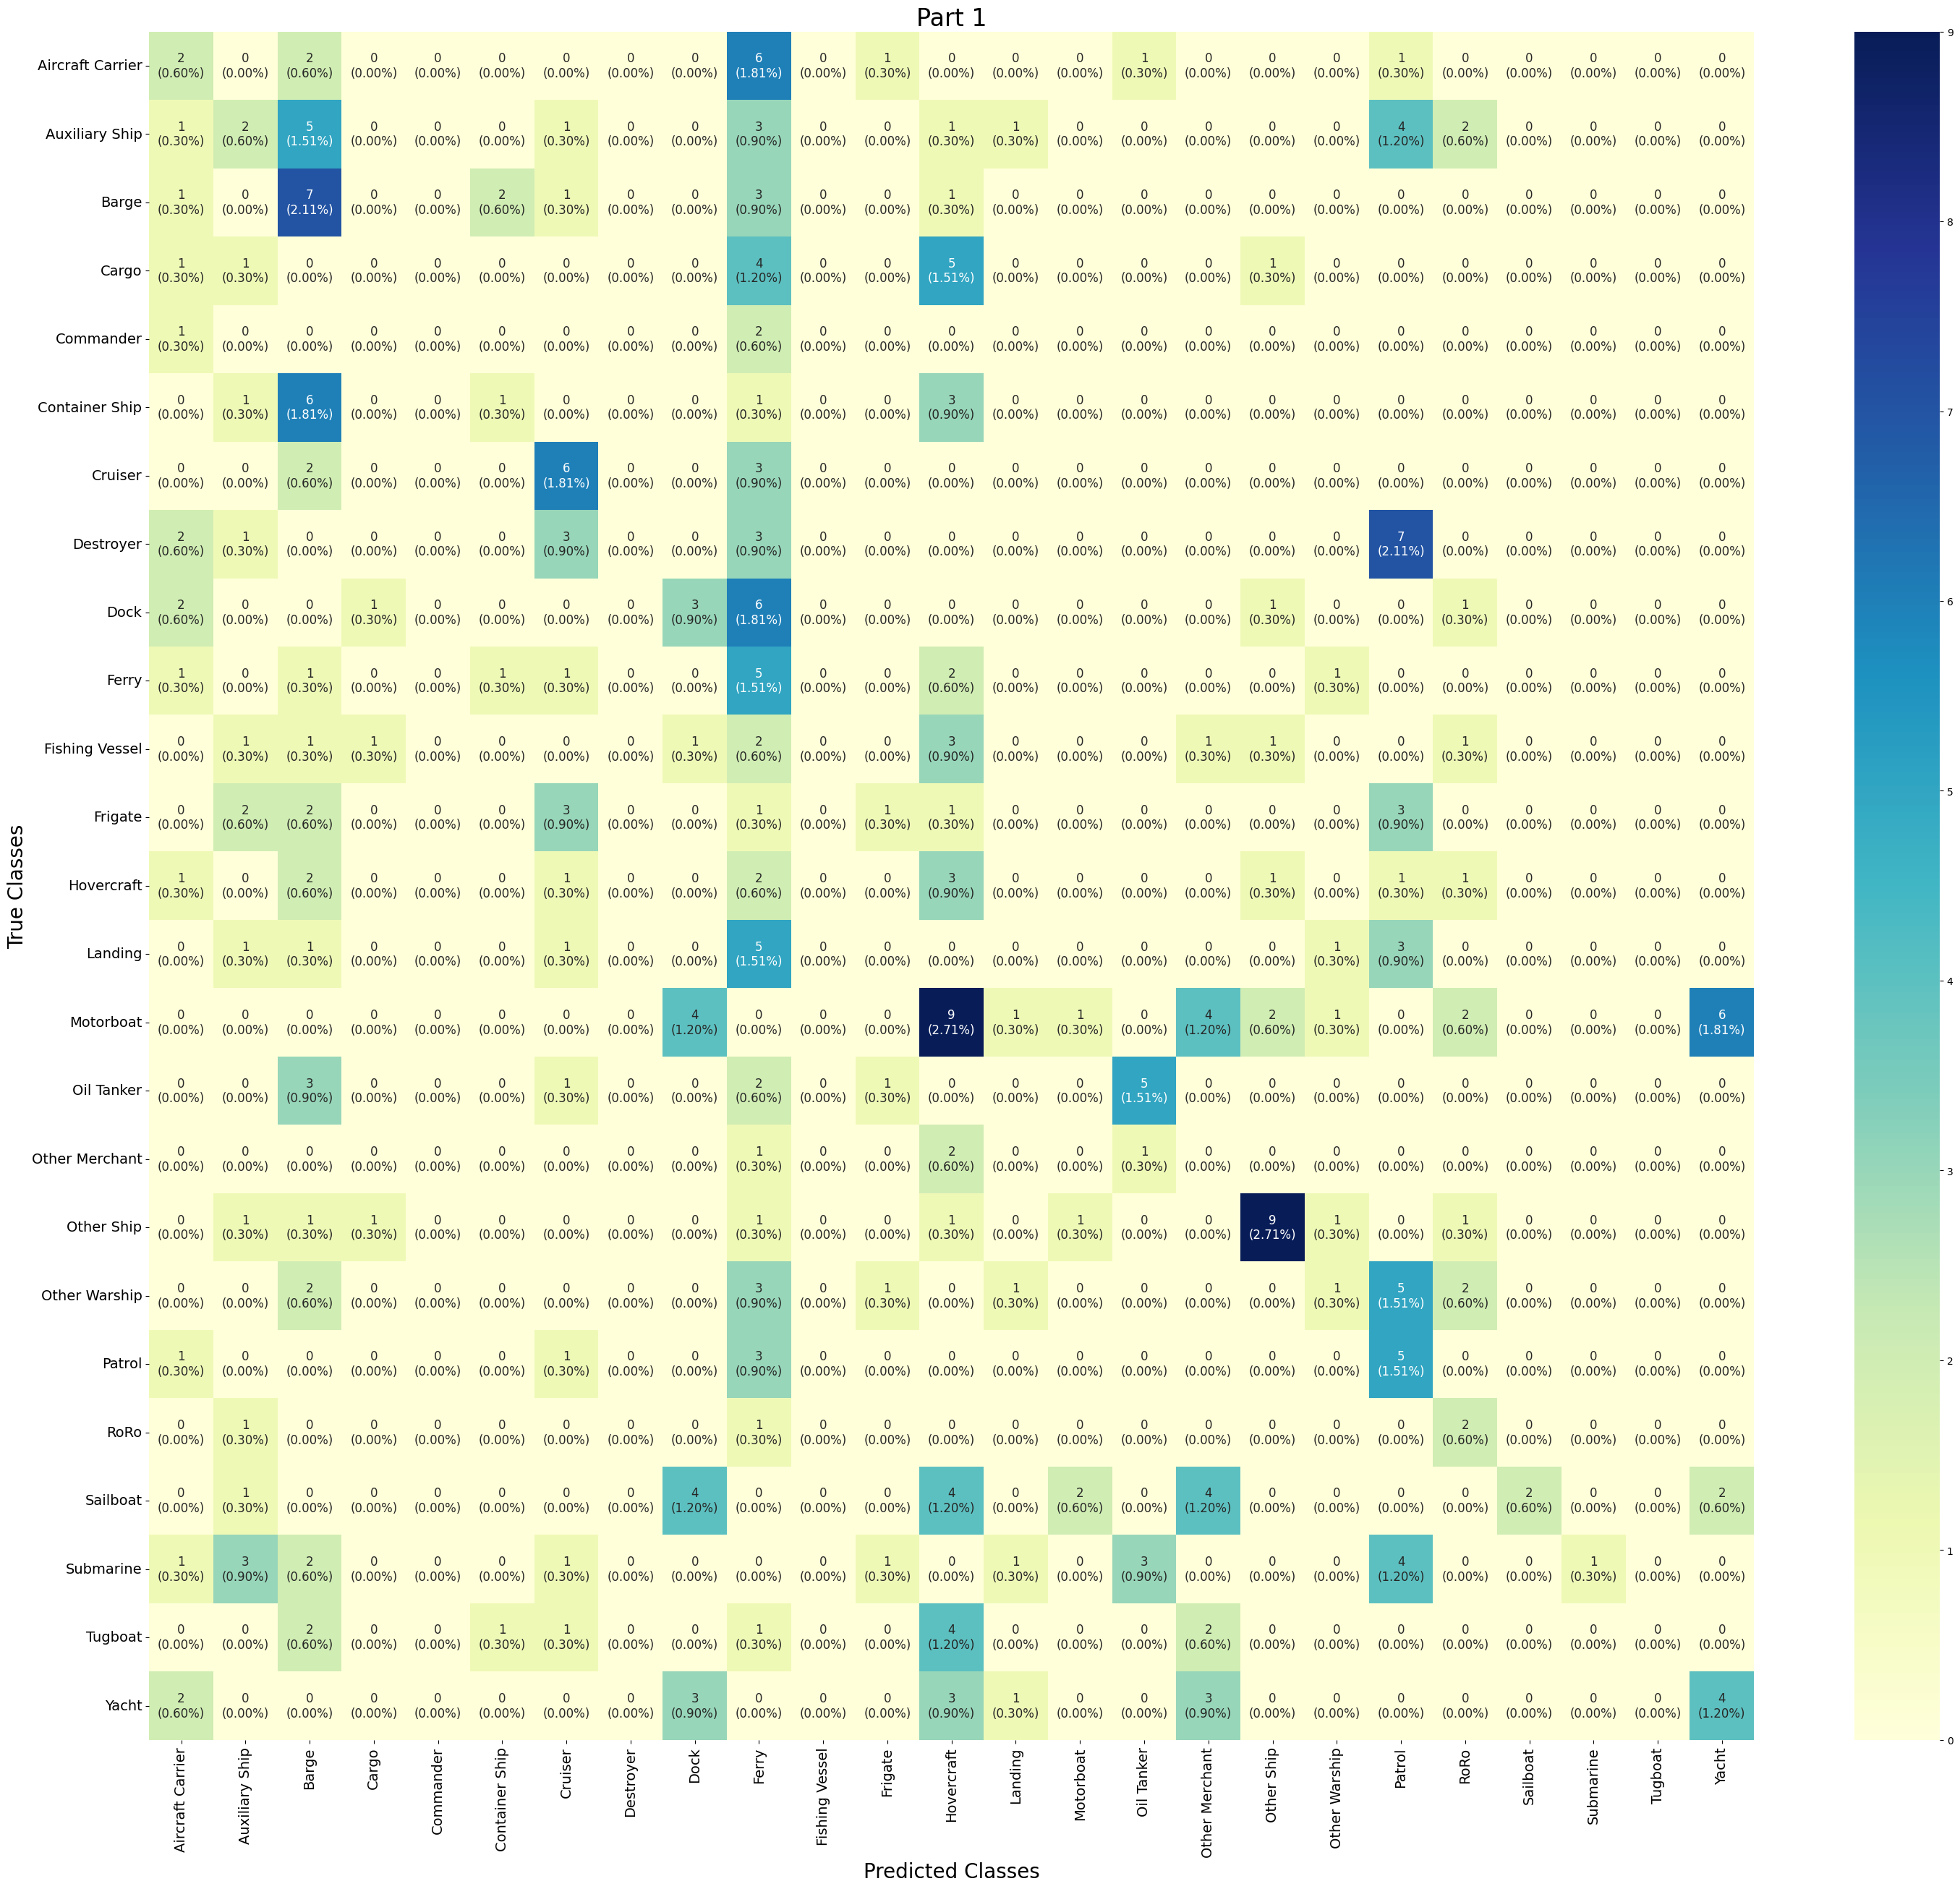

In [44]:
# Hitung confusion matrix
cf_mtx = confusion_matrix(y_true, y_hat)

# Pisahkan menjadi dua bagian
num_classes = 58
mid_point = num_classes // 2

cf_mtx_part1 = cf_mtx[:mid_point, :mid_point]
cf_mtx_part2 = cf_mtx[mid_point:, mid_point:]

class_map_values = list(class_map.values())
class_labels_part1 = class_map_values[:mid_point]
class_labels_part2 = class_map_values[mid_point:]

def prepare_box_class(cf_mtx):
    group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
    box_class = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    return np.asarray(box_class).reshape(cf_mtx.shape)

box_class_part1 = prepare_box_class(cf_mtx_part1)
box_class_part2 = prepare_box_class(cf_mtx_part2)

plt.figure(figsize=(30, 50))  # Ukuran gambar yang besar untuk dua baris

# Heatmap untuk bagian pertama
plt.subplot(2, 1, 1)
sns.heatmap(cf_mtx_part1, xticklabels=class_labels_part1, yticklabels=class_labels_part1, cmap="YlGnBu", fmt="", annot=box_class_part1, annot_kws={"size": 12})
plt.xlabel('Predicted Classes', fontsize=20)
plt.ylabel('True Classes', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Part 1', fontsize=24)



plt.tight_layout()
plt.show()

In [45]:
print(classification_report(y_true, y_hat, target_names=class_map.values()))

                  precision    recall  f1-score   support

Aircraft Carrier       0.12      0.15      0.14        13
  Auxiliary Ship       0.13      0.10      0.11        20
           Barge       0.18      0.47      0.26        15
           Cargo       0.00      0.00      0.00        12
       Commander       0.00      0.00      0.00         3
  Container Ship       0.20      0.08      0.12        12
         Cruiser       0.29      0.55      0.38        11
       Destroyer       0.00      0.00      0.00        16
            Dock       0.20      0.21      0.21        14
           Ferry       0.09      0.42      0.14        12
  Fishing Vessel       0.00      0.00      0.00        12
         Frigate       0.20      0.08      0.11        13
      Hovercraft       0.07      0.25      0.11        12
         Landing       0.00      0.00      0.00        12
       Motorboat       0.25      0.03      0.06        30
      Oil Tanker       0.50      0.42      0.45        12
  Other Merch

# **WRONG PREDICTION**

In [46]:
y_true = np.array(y_true)
print(y_true.shape)

(332,)


In [47]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[errors]
# print(f'error: {errors}\n')
# print(y_true_errors)
# print(y_true_errors[0])
# print(class_map[y_true_errors[idx]])

y_hat_errors = y_hat[errors]
# print(y_hat_errors)
# print(y_hat_errors[0])
# print(class_map[y_hat_errors[idx]])

In [48]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 332
Jumlah prediksi yang salah: 272
Persentase prediksi yang salah: 81.92771084337349%


In [49]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors] # mengambil images yang error

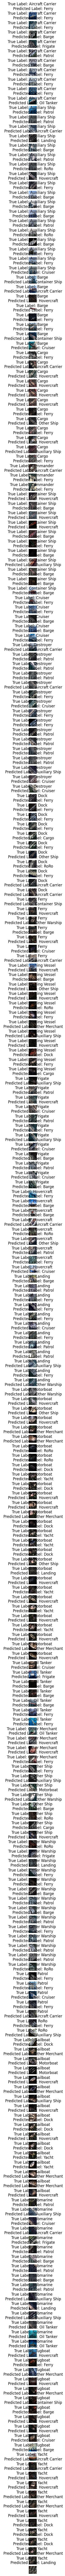

In [50]:
fig, ax = plt.subplots(nrows=total_errors, ncols=1, figsize=(90, 150))

for idx, error in enumerate(y_true_errors):
    true_label = labels[error]
    predicted_label = labels[y_hat_errors[idx]]
    ax[idx].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
    img_path = os.path.join(test_path, test_img[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(img)
    ax[idx].axis("off")

plt.tight_layout()
# plt.suptitle('All Wrong Predictions made on test set', fontsize=20)
plt.show()

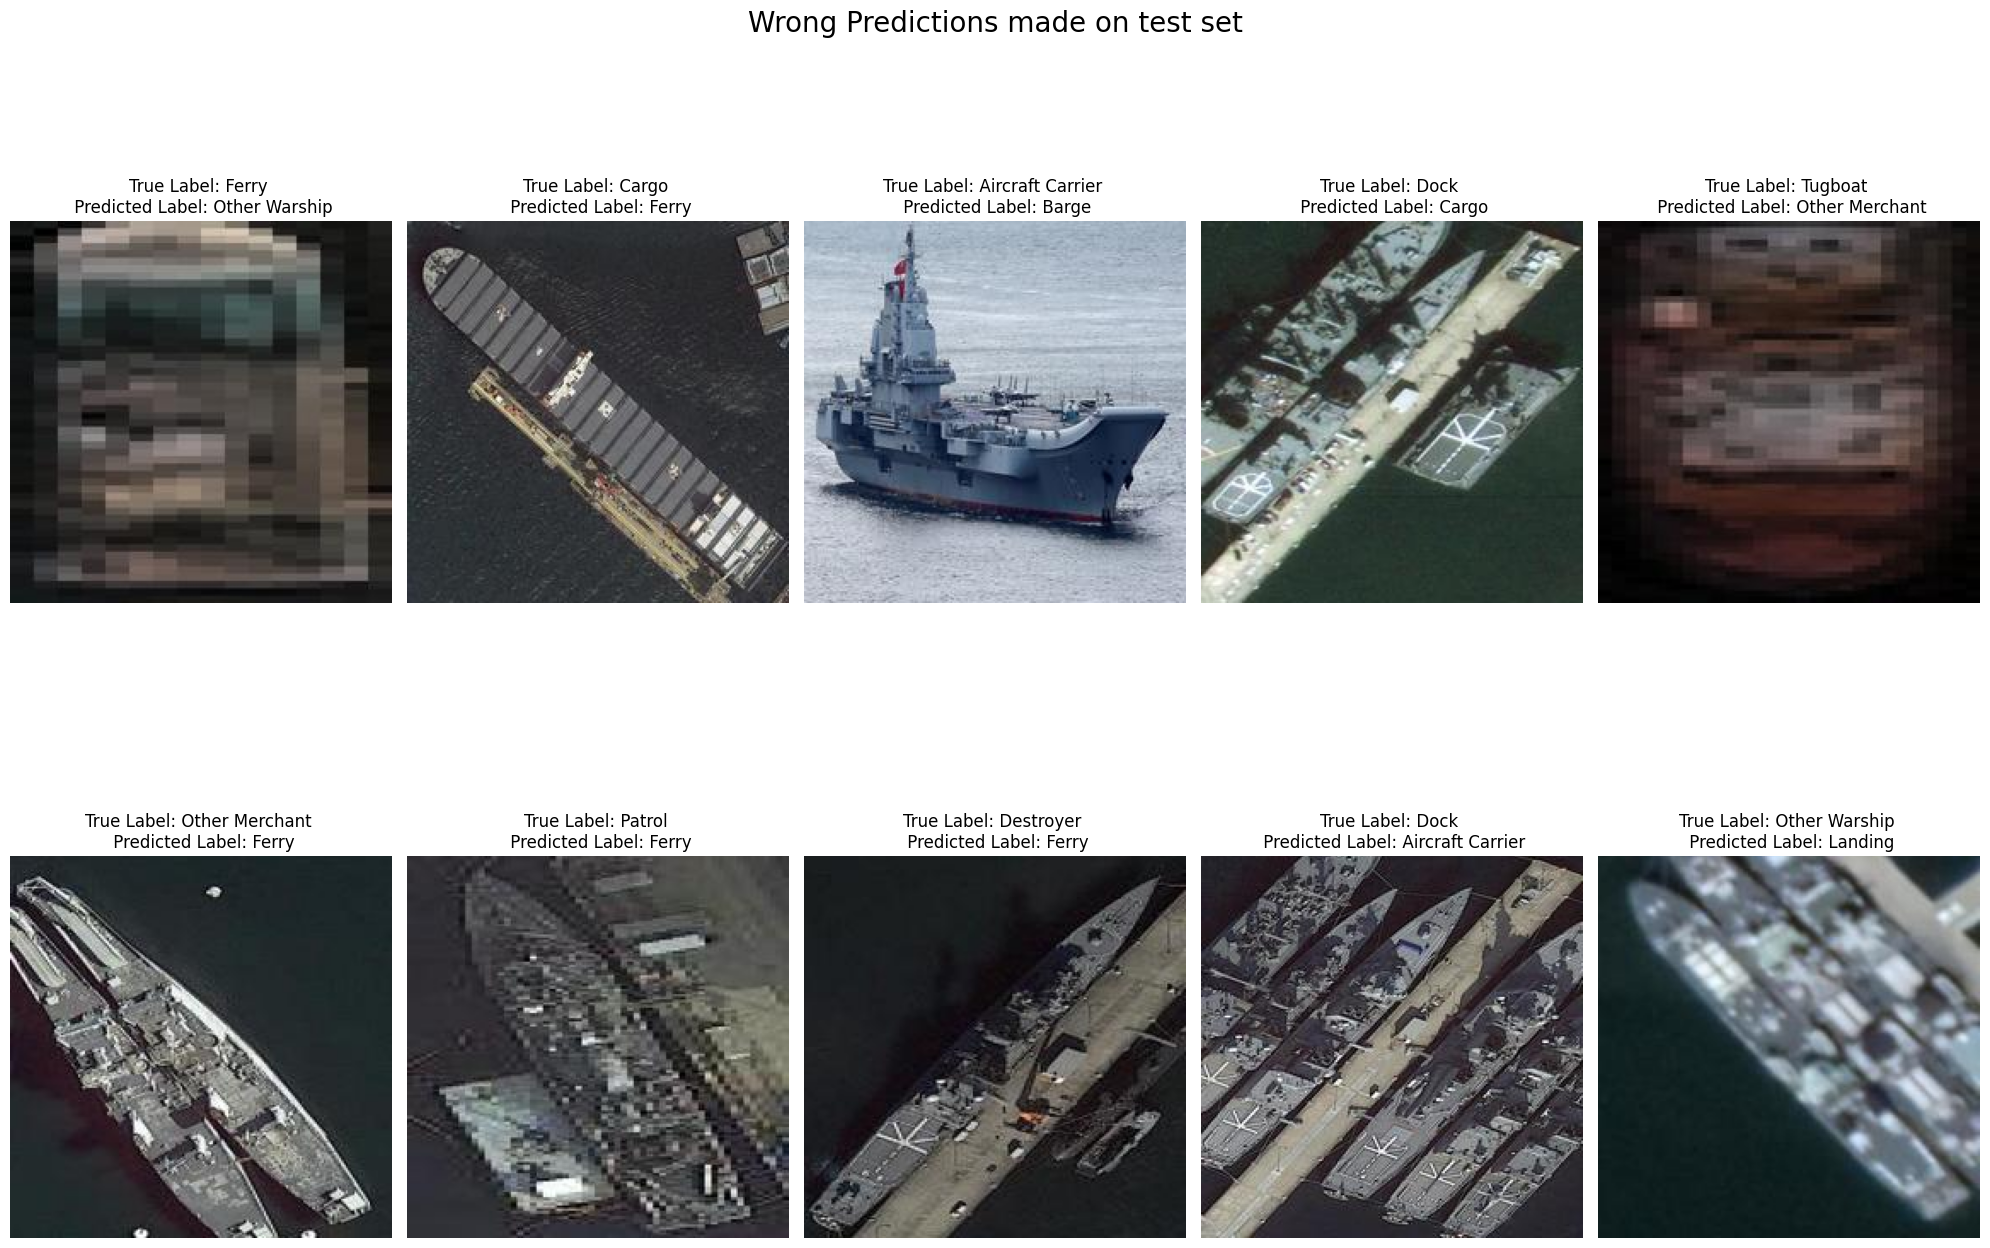

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_class = class_map[true_index]

        predicted_index = y_hat_errors[idx]
        predicted_class = class_map[predicted_index]

        ax[i, j].set_title(f"True Label: {true_class} \n Predicted Label: {predicted_class}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [52]:
model.save("//content/drive/MyDrive/Colab Notebooks/UAP/CNN.h5")